# PyTorch ResNet-50 CIFAR-10 Benchmarks

In [1]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  8
  On-line CPU(s) list:   0-7
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.80GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  4
    Socket(s):           1
    Stepping:            7
    BogoMIPS:            5600.52
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid tsc_known_freq pni pclmulqdq sss
                         e3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes 
                         xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowpref

## device=cpu w/o Intel Extension for PyTorch

In [2]:
import torch
import torchvision

In [3]:
LR = 0.001
DOWNLOAD = True
DATA = 'datasets/cifar10/'
device = 'cpu'

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=True,
        transform=transform,
        download=DOWNLOAD
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=128,
        
)

Files already downloaded and verified


In [5]:
model = torchvision.models.resnet50()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.9)

In [6]:
%%time

loss_plot = []

model.train()

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    loss_plot.append(loss.item())
    print('batch_idx: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        batch_idx, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

batch_idx: 0 [0/50000 (0%)]	Loss: 7.234754
batch_idx: 1 [128/50000 (0%)]	Loss: 7.086808
batch_idx: 2 [256/50000 (1%)]	Loss: 6.735826
batch_idx: 3 [384/50000 (1%)]	Loss: 6.198445
batch_idx: 4 [512/50000 (1%)]	Loss: 5.612561
batch_idx: 5 [640/50000 (1%)]	Loss: 5.131405
batch_idx: 6 [768/50000 (2%)]	Loss: 4.504273
batch_idx: 7 [896/50000 (2%)]	Loss: 4.078146
batch_idx: 8 [1024/50000 (2%)]	Loss: 3.391612
batch_idx: 9 [1152/50000 (2%)]	Loss: 2.967665
batch_idx: 10 [1280/50000 (3%)]	Loss: 2.698241
batch_idx: 11 [1408/50000 (3%)]	Loss: 2.491864
batch_idx: 12 [1536/50000 (3%)]	Loss: 2.508377
batch_idx: 13 [1664/50000 (3%)]	Loss: 2.428982
batch_idx: 14 [1792/50000 (4%)]	Loss: 2.332119
batch_idx: 15 [1920/50000 (4%)]	Loss: 2.428419
batch_idx: 16 [2048/50000 (4%)]	Loss: 2.367677
batch_idx: 17 [2176/50000 (4%)]	Loss: 2.435892
batch_idx: 18 [2304/50000 (5%)]	Loss: 2.345340
batch_idx: 19 [2432/50000 (5%)]	Loss: 2.316924
batch_idx: 20 [2560/50000 (5%)]	Loss: 2.358939
batch_idx: 21 [2688/50000 (5%)]	L

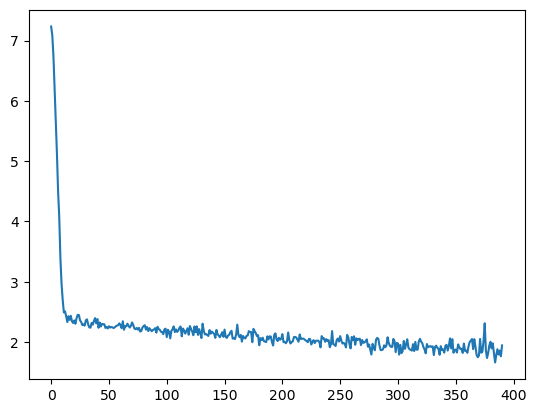

In [7]:
import matplotlib.pyplot as plt

X = range(len(loss_plot))
Y = loss_plot
plt.plot(X, Y)
plt.show()

In [8]:
torch.save({
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     }, 'checkpoint.pth')

In [9]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [10]:
%%time

model.eval()

test_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=False,
        transform=transform,
        download=DOWNLOAD
)

test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=128,
)

correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 30 %
CPU times: user 17min 43s, sys: 1min 45s, total: 19min 28s
Wall time: 4min 54s


## device=cpu w/ Intel Extension for PyTorch (float32)

In [11]:
!pip install intel_extension_for_pytorch
import intel_extension_for_pytorch as ipex

In [12]:
model = torchvision.models.resnet50()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.9)

In [13]:
%%time

loss_plot = []

model.train()
model, optimizer = ipex.optimize(model, optimizer=optimizer)

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    loss_plot.append(loss.item())
    print('batch_idx: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        batch_idx, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

batch_idx: 0 [0/50000 (0%)]	Loss: 7.034572
batch_idx: 1 [128/50000 (0%)]	Loss: 6.844923
batch_idx: 2 [256/50000 (1%)]	Loss: 6.516326
batch_idx: 3 [384/50000 (1%)]	Loss: 6.004021
batch_idx: 4 [512/50000 (1%)]	Loss: 5.434774
batch_idx: 5 [640/50000 (1%)]	Loss: 4.818243
batch_idx: 6 [768/50000 (2%)]	Loss: 4.346886
batch_idx: 7 [896/50000 (2%)]	Loss: 3.882392
batch_idx: 8 [1024/50000 (2%)]	Loss: 3.342541
batch_idx: 9 [1152/50000 (2%)]	Loss: 2.948830
batch_idx: 10 [1280/50000 (3%)]	Loss: 2.755704
batch_idx: 11 [1408/50000 (3%)]	Loss: 2.621944
batch_idx: 12 [1536/50000 (3%)]	Loss: 2.427262
batch_idx: 13 [1664/50000 (3%)]	Loss: 2.292280
batch_idx: 14 [1792/50000 (4%)]	Loss: 2.290982
batch_idx: 15 [1920/50000 (4%)]	Loss: 2.406553
batch_idx: 16 [2048/50000 (4%)]	Loss: 2.311927
batch_idx: 17 [2176/50000 (4%)]	Loss: 2.430666
batch_idx: 18 [2304/50000 (5%)]	Loss: 2.337689
batch_idx: 19 [2432/50000 (5%)]	Loss: 2.367846
batch_idx: 20 [2560/50000 (5%)]	Loss: 2.335001
batch_idx: 21 [2688/50000 (5%)]	L

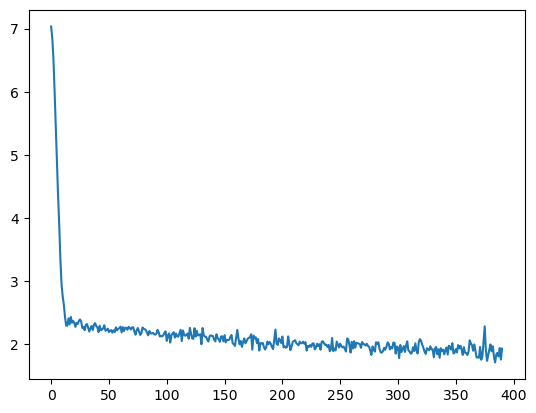

In [14]:
import matplotlib.pyplot as plt

X = range(len(loss_plot))
Y = loss_plot
plt.plot(X, Y)
plt.show()

In [15]:
torch.save({
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     }, 'checkpoint.pth')

In [16]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [17]:
%%time

model.eval()

model = ipex.optimize(model)

test_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=False,
        transform=transform,
        download=DOWNLOAD
)

test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=128,
)

correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 27 %
CPU times: user 13min 54s, sys: 1min 41s, total: 15min 35s
Wall time: 3min 55s


## device=cpu w/ Intel Extension for PyTorch (bfloat16)

In [18]:
model = torchvision.models.resnet50()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.9)

In [19]:
%%time

loss_plot = []

model.train()
model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    with torch.cpu.amp.autocast():
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
    optimizer.step()
    loss_plot.append(loss.item())
    print('batch_idx: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        batch_idx, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

batch_idx: 0 [0/50000 (0%)]	Loss: 7.022343
batch_idx: 1 [128/50000 (0%)]	Loss: 6.894228
batch_idx: 2 [256/50000 (1%)]	Loss: 6.473960
batch_idx: 3 [384/50000 (1%)]	Loss: 6.089163
batch_idx: 4 [512/50000 (1%)]	Loss: 5.537049
batch_idx: 5 [640/50000 (1%)]	Loss: 4.829256
batch_idx: 6 [768/50000 (2%)]	Loss: 4.581520
batch_idx: 7 [896/50000 (2%)]	Loss: 3.926723
batch_idx: 8 [1024/50000 (2%)]	Loss: 3.346767
batch_idx: 9 [1152/50000 (2%)]	Loss: 2.835621
batch_idx: 10 [1280/50000 (3%)]	Loss: 2.664696
batch_idx: 11 [1408/50000 (3%)]	Loss: 2.542508
batch_idx: 12 [1536/50000 (3%)]	Loss: 2.520819
batch_idx: 13 [1664/50000 (3%)]	Loss: 2.387519
batch_idx: 14 [1792/50000 (4%)]	Loss: 2.267849
batch_idx: 15 [1920/50000 (4%)]	Loss: 2.394410
batch_idx: 16 [2048/50000 (4%)]	Loss: 2.336658
batch_idx: 17 [2176/50000 (4%)]	Loss: 2.379292
batch_idx: 18 [2304/50000 (5%)]	Loss: 2.310026
batch_idx: 19 [2432/50000 (5%)]	Loss: 2.338507
batch_idx: 20 [2560/50000 (5%)]	Loss: 2.355665
batch_idx: 21 [2688/50000 (5%)]	L

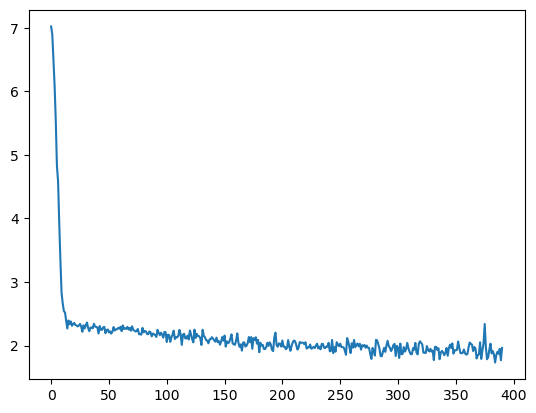

In [20]:
import matplotlib.pyplot as plt

X = range(len(loss_plot))
Y = loss_plot
plt.plot(X, Y)
plt.show()

In [21]:
torch.save({
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     }, 'checkpoint.pth')

In [22]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

- torch.cpu.amp.autocast() below will automatically cast to torch.bfloat16
- Model optimization is unneeded here since the model is already optimized; however, if you run the code blocks out-of-order, then this ensures the model is optimized by IPEX
- Note the insertion of the IPEXConv2d & IPEXLinear layers below

In [23]:
%%time

model.eval()

# Optimize model for inference w/ IPEX
model = ipex.optimize(model, dtype=torch.bfloat16)

print(model)

test_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=False,
        transform=transform,
        download=DOWNLOAD
)

test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=128,
)

correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        # automatically cast to torch.bfloat16
        with torch.cpu.amp.autocast():
            output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

GraphModule(
  (conv1): _IPEXConv2d()
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): _IPEXConv2d()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): _IPEXConv2d()
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): _IPEXConv2d()
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Module(
        (0): _IPEXConv2d()
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Module(
      (conv1): _IPEXConv2d()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL